<a href="https://colab.research.google.com/github/Gottyokit/LearningAndPractice/blob/main/JustTesting001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Preprocesamiento] Muestra de datos sintéticos generados:
+-----------------------------------------+----------------------------------------------+--------------+---------------+
|              Original (X)               |                Sintético (X)                 | Original (y) | Sintético (y) |
+-----------------------------------------+----------------------------------------------+--------------+---------------+
| [28.3, 26.1, 9.01, 303.0, 8191.0, 0.0]  | [28.32, 26.12, 9.02, 303.04, 8191.07, -0.01] |     0.2      |     0.207     |
| [26.9, 22.7, 8.7, 303.0, 4800.0, 500.0] | [26.98, 22.62, 8.78, 302.98, 4800.0, 500.0]  |     0.12     |     0.106     |
| [26.9, 22.7, 8.7, 303.0, 4800.0, 500.0] | [26.9, 22.68, 8.76, 303.0, 4799.99, 499.99]  |     0.12     |     0.118     |
+-----------------------------------------+----------------------------------------------+--------------+---------------+

Predicción en prueba: 0.1607 (Valor real: 0.15)
MAE:  0.0253
RMSE: 0.0320
R²:   0.8057

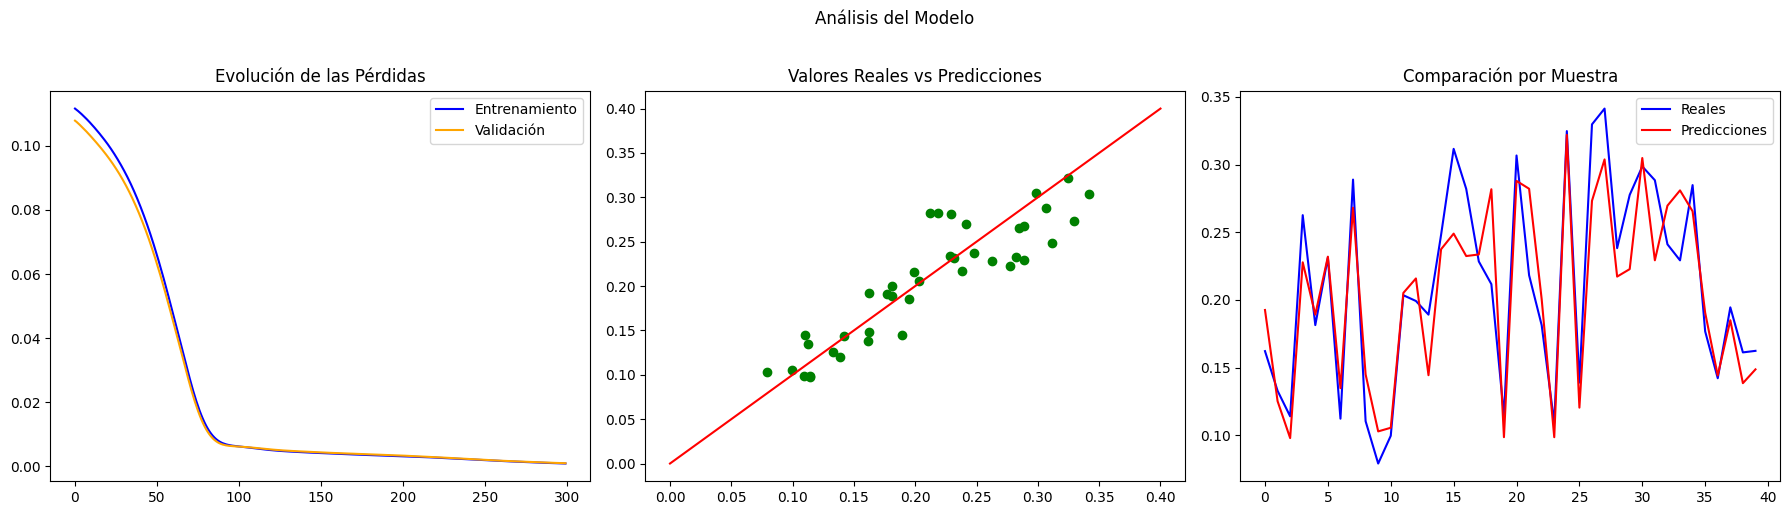

In [21]:
# ========================================================
# Importación de Bibliotecas
# ========================================================
# - Bibliotecas principales para redes neuronales y cálculo numérico
# - Herramientas para visualización y métricas de evaluación
# - Preprocesamiento de datos y manejo de tensores

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
from tabulate import tabulate

# ========================================================
# Configuración Personalizable del Modelo y Entrenamiento
# ========================================================
# - Arquitectura de la red: capas ocultas y funciones de activación
# - Hiperparámetros de entrenamiento: learning rate, épocas, paciencia para early stopping
# - Esquema de colores para visualizaciones

config = {
    "network_architecture": {
        "hidden_layers": [32, 16, 8],  # Número de neuronas por capa oculta
        "activation": nn.ReLU,        # Función de activación
        "output_activation": nn.Sigmoid  # Activación para la capa de salida
    },
    "training": {
        "learning_rate": 0.001,
        "weight_decay": 1e-4,
        "epochs": 300,
        "early_stopping_patience": 15
    },
    "plot_colors": {
        "training_loss": "blue",
        "validation_loss": "orange",
        "scatter_points": "green",
        "scatter_line": "red",
        "real_values": "blue",
        "predicted_values": "red"
    }
}

# ========================================================
# Generación de Datos Sintéticos
# ========================================================
# Función para crear datos artificiales añadiendo ruido a los datos originales
# - Aumenta el tamaño del dataset para mejor entrenamiento
# - Muestra ejemplos comparativos en formato tabular

def generate_synthetic_data(base_X, base_y, num_samples=50):
    X, y = [], []
    examples = []

    for _ in range(num_samples):
        # Selección aleatoria de un dato base
        idx = np.random.randint(0, len(base_X))

        # Generación de ruido para características y target
        noise = np.random.normal(0, 0.05, len(base_X[idx]))
        synthetic_sample = np.array(base_X[idx]) + noise
        synthetic_target = base_y[idx] + np.random.normal(0, 0.015)

        # Almacenamiento de ejemplos demostrativos
        if _ < 3:
            examples.append({
                "Original (X)": np.round(base_X[idx], 2).tolist(),
                "Sintético (X)": np.round(synthetic_sample, 2).tolist(),
                "Original (y)": float(base_y[idx]),
                "Sintético (y)": round(float(synthetic_target), 3)
            })

        X.append(synthetic_sample)
        y.append(np.clip(synthetic_target, 0.0, 0.5))

    # Visualización de ejemplos en tabla
    print("\n[Preprocesamiento] Muestra de datos sintéticos generados:")
    print(tabulate(examples, headers="keys", tablefmt="pretty", stralign="center"))

    return np.array(X), np.array(y)

# ========================================================
# Dataset Original de Referencia
# ========================================================
# - 10 muestras base con 6 características cada una
# - Targets correspondientes entre 0.10 y 0.32

base_data = {
    "X": [
        [27.9, 23.3, 9.54, 303.0, 4254.0, 0],
        [28.3, 26.1, 9.01, 303.0, 8191.0, 0],
        [26.6, 24.6, 9.01, 303.0, 9023.0, 4012],
        [27.2, 22.5, 8.48, 303.0, 4077.0, 0],
        [28.0, 25.0, 9.30, 303.0, 6000.0, 2000],
        [27.5, 24.0, 9.10, 303.0, 7500.0, 1500],
        [26.8, 23.5, 8.90, 303.0, 5000.0, 1000],
        [27.3, 24.8, 9.20, 303.0, 6700.0, 2500],
        [28.1, 25.6, 9.50, 303.0, 7200.0, 3000],
        [26.9, 22.7, 8.70, 303.0, 4800.0, 500]
    ],
    "y": [0.30, 0.20, 0.10, 0.25, 0.22, 0.18, 0.15, 0.28, 0.32, 0.12]
}

# Generación y escalado de datos
X_train, y_train = generate_synthetic_data(base_data["X"], base_data["y"], num_samples=200)
X_test = [[26.6, 25.7, 9.01, 303.0, 8040.0, 3937]]
y_test = [0.15]

# Normalización de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================================
# Arquitectura de la Red Neuronal
# ========================================================
# Clase personalizable que construye la red según la configuración:
# - Capas lineales intercaladas con funciones de activación
# - Capa final con activación sigmoide para restringir la salida entre 0-1

class CustomizableModel(nn.Module):
    def __init__(self, input_size, config):
        super().__init__()
        layers = []
        prev_size = input_size

        # Construcción dinámica de capas ocultas
        for size in config["hidden_layers"]:
            layers.append(nn.Linear(prev_size, size))
            layers.append(config["activation"]())
            prev_size = size

        # Capa de salida con activación especificada
        layers.append(nn.Linear(prev_size, 1))
        layers.append(config["output_activation"]())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ========================================================
# Configuración de Entrenamiento
# ========================================================
# - Inicialización del modelo con parámetros de la configuración
# - Optimizador Adam con descenso de peso (weight decay)
# - Programador de tasa de aprendizaje (ReduceLROnPlateau)
# - Función de pérdida MSE
# - División de datos en entrenamiento/validación (80/20%)

model = CustomizableModel(X_train_scaled.shape[1], config["network_architecture"])
optimizer = optim.Adam(model.parameters(),
                      lr=config["training"]["learning_rate"],
                      weight_decay=config["training"]["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
loss_fn = nn.MSELoss()

# Preparación de tensores PyTorch
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

train_data = torch.tensor(X_train_split, dtype=torch.float32)
train_targets = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1)
val_data = torch.tensor(X_val_split, dtype=torch.float32)
val_targets = torch.tensor(y_val_split, dtype=torch.float32).view(-1, 1)

# ========================================================
# Ciclo de Entrenamiento con Early Stopping
# ========================================================
# - Registro de pérdidas en entrenamiento y validación
# - Guardado del mejor modelo basado en pérdida de validación
# - Parada anticipada si no hay mejora en "early_stopping_patience" épocas

train_losses, val_losses = [], []
best_loss, patience, bad_epochs = float('inf'), config["training"]["early_stopping_patience"], 0

for epoch in range(config["training"]["epochs"]):
    # Fase de entrenamiento
    model.train()
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = loss_fn(outputs, train_targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Fase de validación
    model.eval()
    with torch.no_grad():
        val_preds = model(val_data)
        val_loss = loss_fn(val_preds, val_targets).item()
        val_losses.append(val_loss)

    # Lógica de Early Stopping
    if val_loss < best_loss:
        best_loss, bad_epochs = val_loss, 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f'\n[Entrenamiento] Early stopping en época {epoch+1}')
        break

# ========================================================
# Evaluación del Modelo
# ========================================================
# - Carga del mejor modelo guardado
# - Cálculo de métricas de rendimiento (MAE, RMSE, R²)
# - Predicción en el conjunto de prueba

model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

with torch.no_grad():
    test_data = torch.tensor(X_test_scaled, dtype=torch.float32)
    test_pred = model(test_data).item()

# Cálculo de métricas en validación
val_preds = model(val_data).detach().numpy().flatten()
mae = mean_absolute_error(y_val_split, val_preds)
rmse = np.sqrt(mean_squared_error(y_val_split, val_preds))
r2 = r2_score(y_val_split, val_preds)

# Reporte de resultados
print('\n' + '='*50)
print(f'Predicción en prueba: {test_pred:.4f} (Valor real: {y_test[0]})')
print(f'MAE:  {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²:   {r2:.4f}')
print('='*50)

# ========================================================
# Visualización de Resultados
# ========================================================
# 1. Curvas de pérdida de entrenamiento y validación
# 2. Dispersión de predicciones vs valores reales
# 3. Comparación muestra a muestra en validación

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Análisis del Modelo', y=1.02)

# Gráfico 1: Evolución de las Pérdidas
axes[0].plot(train_losses, label='Entrenamiento', color=config["plot_colors"]["training_loss"])
axes[0].plot(val_losses, label='Validación', color=config["plot_colors"]["validation_loss"])
axes[0].set_title('Evolución de las Pérdidas')
axes[0].legend()

# Gráfico 2: Dispersión de Predicciones
axes[1].scatter(y_val_split, val_preds, color=config["plot_colors"]["scatter_points"])
axes[1].plot([0, 0.4], [0, 0.4], config["plot_colors"]["scatter_line"])
axes[1].set_title('Valores Reales vs Predicciones')

# Gráfico 3: Comparación Muestra a Muestra
indices = np.arange(len(y_val_split))
axes[2].plot(indices, y_val_split, label='Reales', color=config["plot_colors"]["real_values"])
axes[2].plot(indices, val_preds, label='Predicciones', color=config["plot_colors"]["predicted_values"])
axes[2].set_title('Comparación por Muestra')
axes[2].legend()

plt.tight_layout()
plt.show()